In [ ]:
"""TODO
 - determine bounds on distance error (bicycle to obstacle) corresponding to time sync error
"""

In [1]:
import os
import subprocess
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lidar
import util

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

%load_ext autoreload
%autoreload 2

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)

In [3]:
DEFAULT_FIGSIZE = (14, 7)

In [4]:
records = lidar.load_records(sync=False)

In [5]:
t5 = records[0].trials[5]

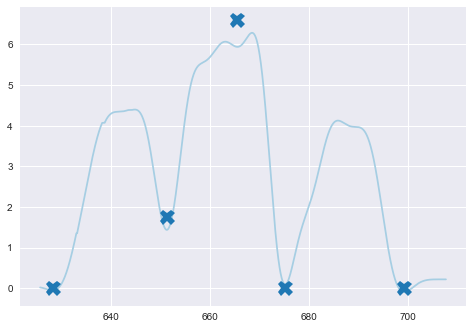

In [6]:
from scipy.signal import cheby1, filtfilt, argrelextrema

fs = 125 # sample-rate 
order = 5
apass = 0.001 # dB
fcut = 0.1 # Hz

wn = fcut / (0.5*fs)
b, a = cheby1(order, apass, wn)

x = t5.speed
y = filtfilt(b, a, x)

colors = sns.color_palette('Paired', 6)
fig, ax = plt.subplots()
ax.plot(t5.time, y, color=colors[0])
ae = argrelextrema(y, np.less)[0]
ax.plot(t5.time[ae], t5.speed[ae], 'X', markersize=15, color=colors[1])
plt.show()

unable to determine valid range for rider 0 trial 0
unable to determine valid range for rider 0 trial 1


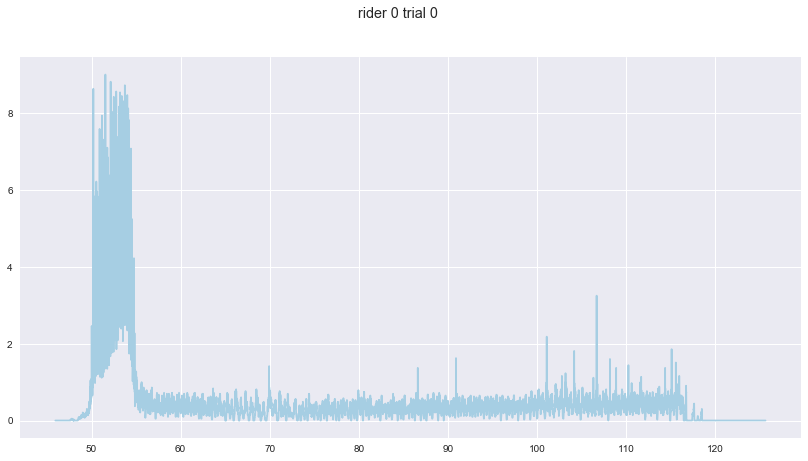

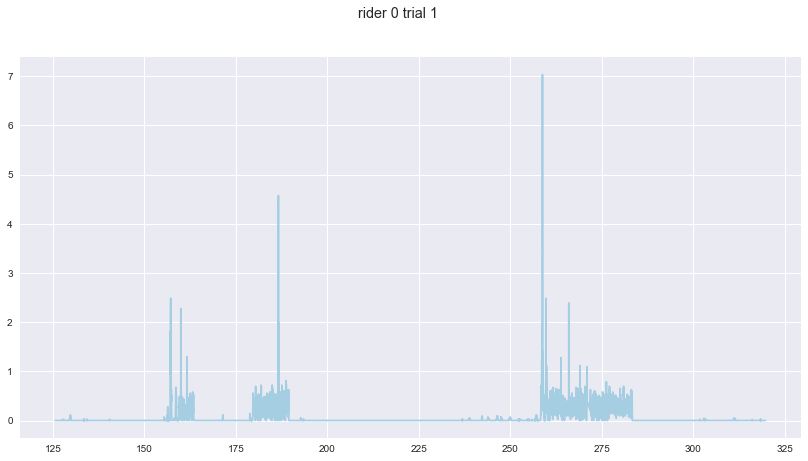

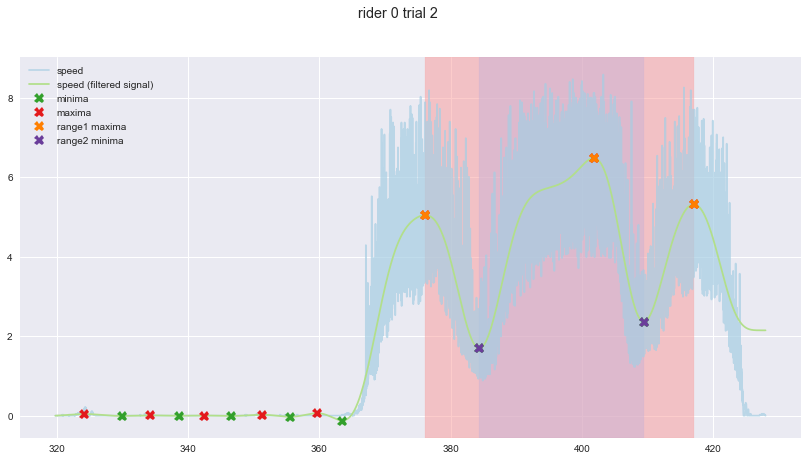

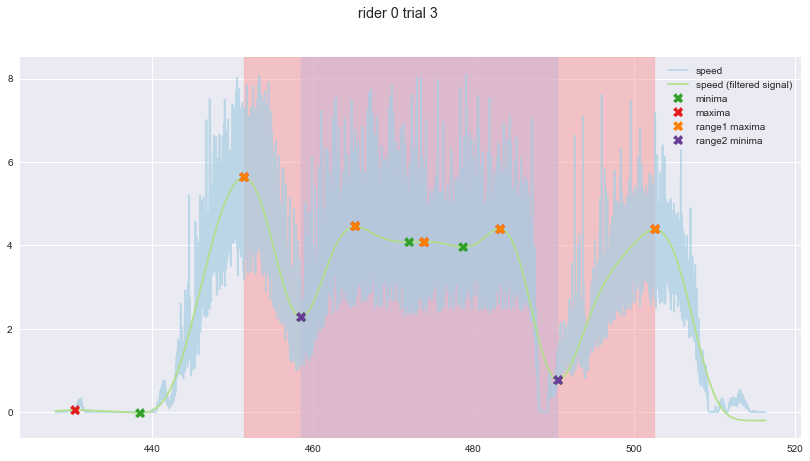

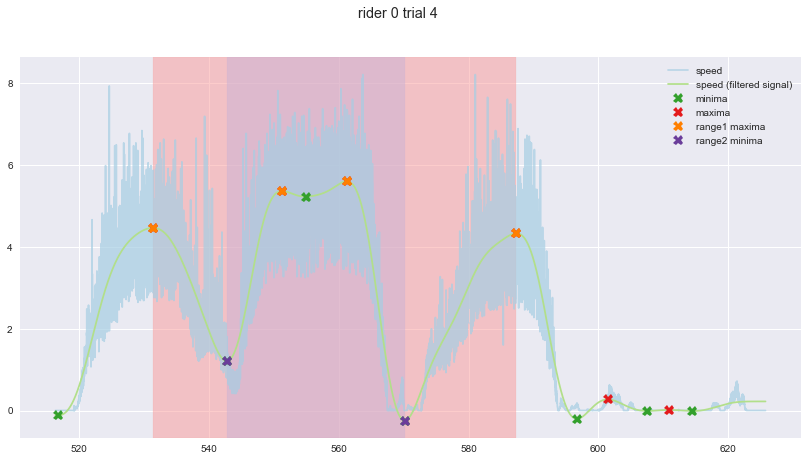

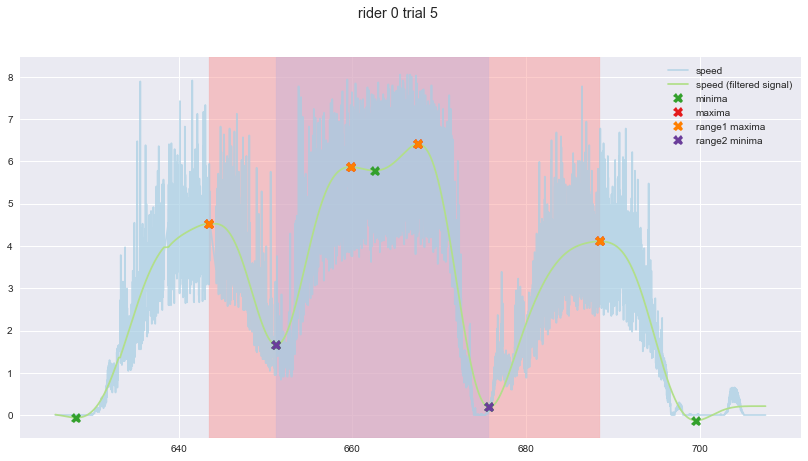

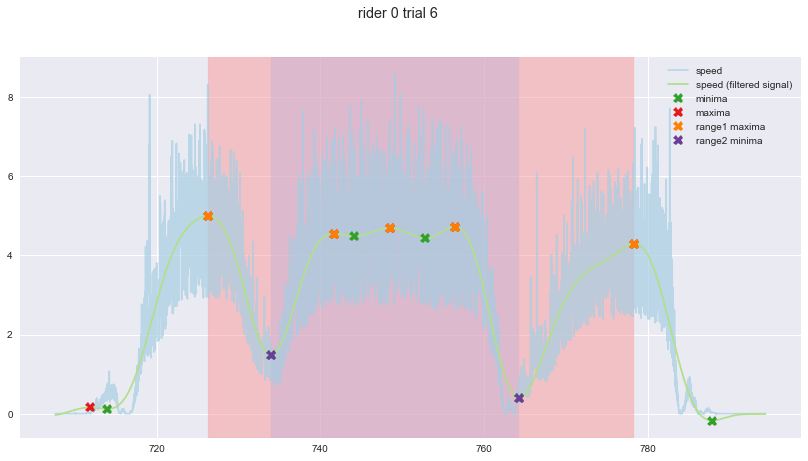

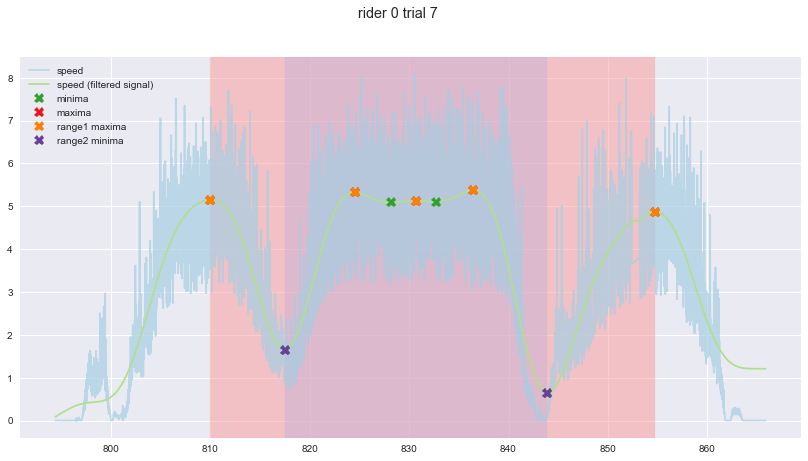

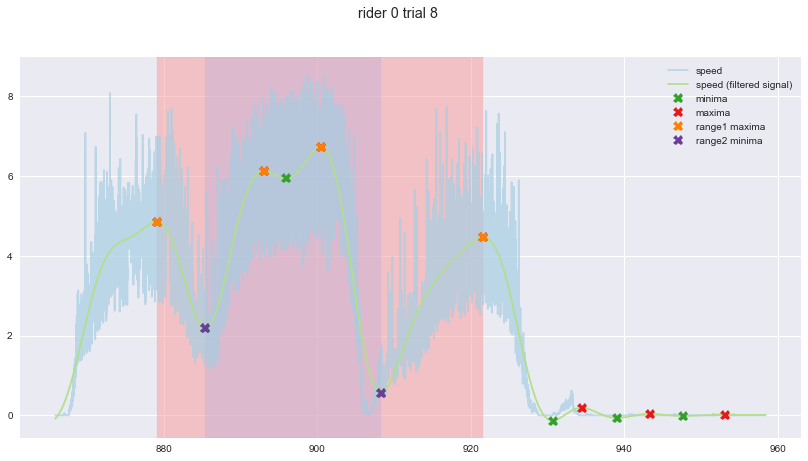

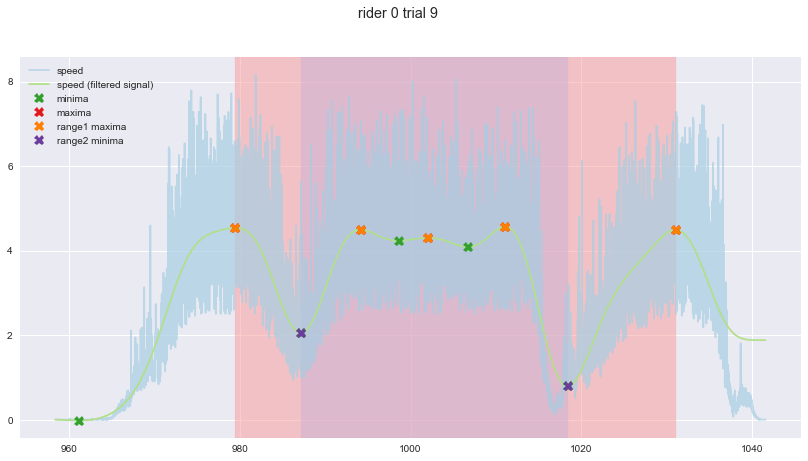

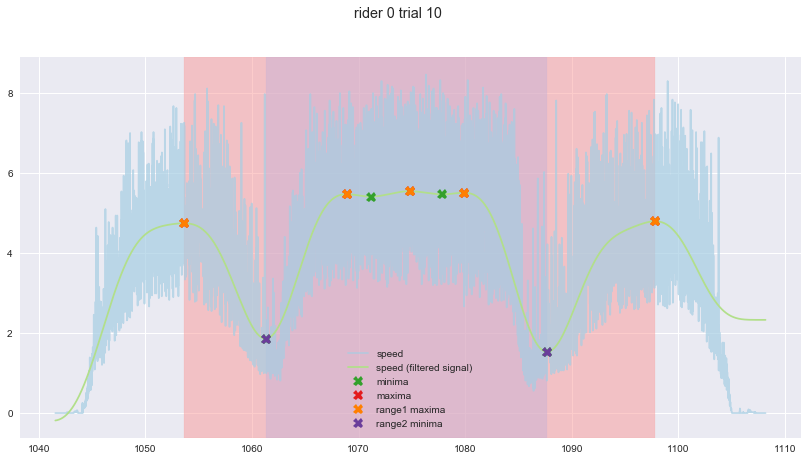

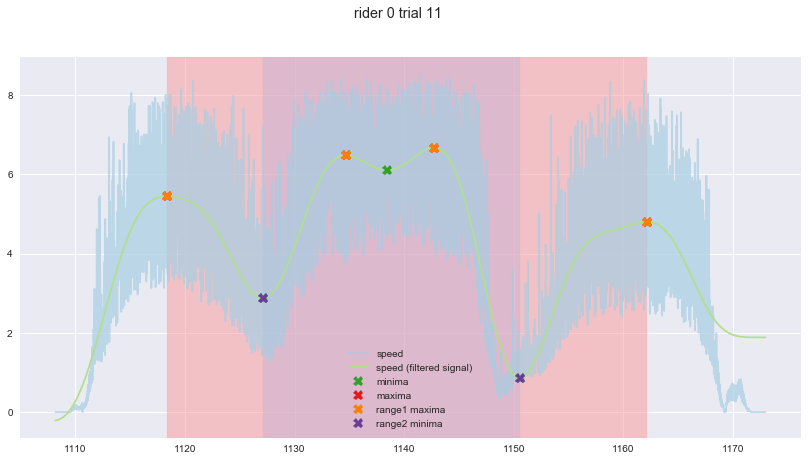

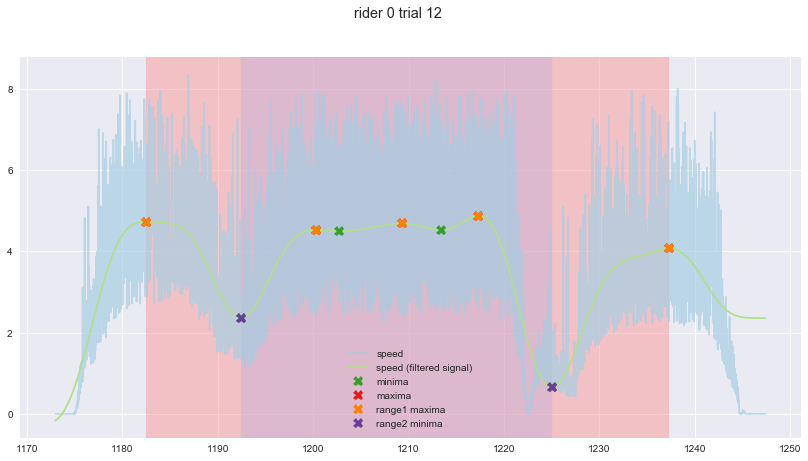

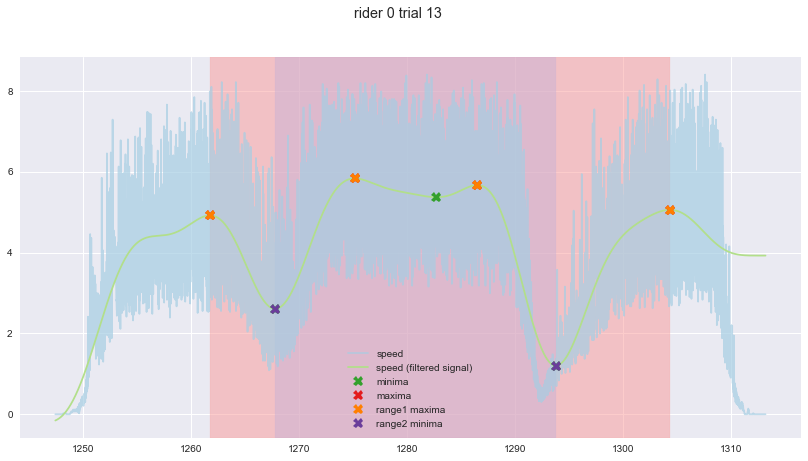

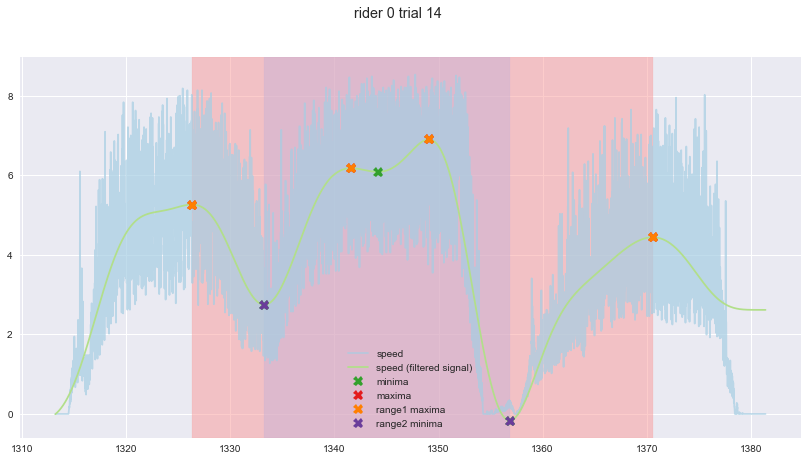

In [7]:
from scipy.signal import cheby1, filtfilt, argrelextrema

def local_extrema(x):
    fs = 125 # sample-rate
    order = 5
    apass = 0.001 # dB
    fcut = 0.08 # Hz
    
    wn = fcut / (0.5*fs)
    b, a = cheby1(order, apass, wn)
    y = filtfilt(b, a, x)
    
    minidx = argrelextrema(y, np.less)[0]
    maxidx = argrelextrema(y, np.greater)[0]
    return minidx, maxidx, y

def plot_trial_ranges(trial, **kwargs):
    RANGE1_LIMIT = 1 # [kph] min filtered speed value for a range 1 maximum
    RANGE2_LIMIT = 0.9 # [percent] RANGE2_LIMIT*min(maxima_r1) is
                       # the max filtered speed value for a range 2 minima
    
    time = trial.time
    signal = trial.speed
    minidx0, maxidx0, filtered_signal = local_extrema(signal)
    
    # range 1 maxima
    maxidx1 = [i for i in maxidx0 if filtered_signal[i] > RANGE1_LIMIT]
    assert len(maxidx1) > 1
    
    # range 2 minima
    a = RANGE2_LIMIT * signal[maxidx1].min()
    minidx2 = [i for i in minidx0
                if (i > maxidx1[0]) and (i < maxidx1[-1]) and (filtered_signal[i] < a)]
    assert len(minidx2) > 1
    
    # reduce range 2 minima to get the ones closest to the 'middle'
    first_middle_r2maximum = maxidx1[np.where(maxidx1 > minidx2[0])[0][0]]
    last_middle_r2maximum = maxidx1[np.where(maxidx1 < minidx2[-1])[0][-1]]
    a = None
    b = None
    for i in minidx2:
        if i < first_middle_r2maximum:
            a = i
        if i > last_middle_r2maximum:
            b = i
            break
    minidx2 = np.array([a, b])
    
    colors = sns.color_palette('Paired', 10)
    _, ax = plt.subplots(**kwargs)
    ax.plot(time, signal, alpha=0.7, color=colors[0], label='speed')
    ax.plot(time, filtered_signal, color=colors[2], label='speed (filtered signal)')
    ax.plot(time[minidx0], filtered_signal[minidx0], 'X', color=colors[3], markersize=10, label='minima')
    ax.plot(time[maxidx0], filtered_signal[maxidx0], 'X', color=colors[5], markersize=10, label='maxima')
    
    ax.axvspan(time[maxidx1[0]], time[maxidx1[-1]], alpha=0.5, color=colors[4])
    ax.plot(time[maxidx1], filtered_signal[maxidx1], 'X', color=colors[7], markersize=10, label='range1 maxima')
    ax.axvspan(time[minidx2[0]], time[minidx2[-1]], alpha=0.5, color=colors[8])
    ax.plot(time[minidx2], filtered_signal[minidx2], 'X', color=colors[9], markersize=10, label='range2 minima')
    
    ax.legend()
    return ax


rid = 0
for i, trial in enumerate(records[rid].trials, 0):
    description = 'rider {} trial {}'.format(rid, i)
    try:
        ax = plot_trial_ranges(trial, figsize=DEFAULT_FIGSIZE)
        set_title(ax, description)
    except AssertionError:
        print('unable to determine valid range for {}'.format(description))
        colors = sns.color_palette('Paired', 10)
        fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
        ax.plot(trial.time, trial.speed, color=colors[0], label='speed')
        set_title(ax, description)
plt.show()